In [1]:
# This is required to run multiple processes on Unity for some reason.
from multiprocessing import set_start_method
set_start_method('spawn', force=True)


import os
os.environ['XLA_FLAGS'] = '--xla_gpu_enable_command_buffer='
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.7'
# os.environ['JAX_PLATFORMS'] = 'cpu'

In [2]:
%matplotlib widget
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from tqdm.auto import tqdm
from pathlib import Path
from importlib import reload

src = str(Path('../src').resolve())
if src not in sys.path:
    sys.path.append(src)
import config, data, models, train, evaluate

In [3]:
# reload(config)
from config import read_config

cfg, cfg_str = read_config("../runs/GraphLSTM/Ohio_runoff.yml")
# cfg['num_workers'] = 1
cfg['log'] = False
cfg['quiet'] = False
# cfg['batch_size'] = 256


In [4]:
reload(data)
from data import HydroDataset

dataset = HydroDataset(cfg)

Loading static attributes
Loading dynamic data
Data Hash: 96c6f77c905c66f99cfc280d53a3e32466fcfc55431816e57082d50f393b071c
Using cached basin dataset.


In [5]:
# reload(config)
from config import set_model_data_args
from data import HydroDataLoader


cfg = set_model_data_args(cfg, dataset)
dataloader = HydroDataLoader(cfg, dataset)

Dataloader using 1 parallel CPU worker(s).
Batch sharding set to 1 gpu(s)


In [ ]:
for basin, date, batch in dataloader:
    break

In [ ]:
def mse_loss(y, y_pred, mask):
    mse = jnp.mean(jnp.square(y - y_pred), where=mask)
    return mse

model = trainer.model

y_pred = jax.vmap(model)(batch, None)
y = batch['y'][:,-1,...]
valid_mask = ~jnp.isnan(y)
masked_y = jnp.where(valid_mask, y, 0)
masked_y_pred = jnp.where(valid_mask, y_pred, 0)

vectorized_loss_fn = jax.vmap(mse_loss, in_axes=(-1, -1, -1))
raw_losses = vectorized_loss_fn(masked_y, masked_y_pred, valid_mask)

target_weights = cfg['step_kwargs']['target_weights']
valid_loss = ~jnp.isnan(raw_losses)
target_losses = jnp.where(valid_loss, raw_losses, 0)
target_weights = valid_loss * jnp.array(target_weights)

loss = jnp.average(target_losses, weights=target_weights)
loss

In [ ]:
from train import Trainer

trainer = Trainer(cfg, dataloader)
trainer.start_training()

In [ ]:
model = trainer.model
model.rg_lstm.graph_matrix.device

In [ ]:
dataloader.sharding

In [ ]:
jax.devices()

In [3]:
from data import HydroDataset, HydroDataLoader

state_file = Path("/work/pi_kandread_umass_edu/tss-ml/runs/GraphLSTM/Ohio_discharge_static_20250206_182923")
cfg, model, trainer_state, opt_state, _  = train.load_last_state(state_file)
cfg['log'] = False
cfg['quiet'] = False
dataset = HydroDataset(cfg)
dataset.update_indices('test')
dataloader = HydroDataLoader(cfg, dataset)

results = evaluate.predict(model, dataloader)

Loading model state from /work/pi_kandread_umass_edu/tss-ml/runs/GraphLSTM/Ohio_discharge_static_20250206_182923/epoch030
Model contains 1,864,211 parameters, using 7.11MB memory.
Loading static attributes
Dropping numerical attributes with 0 variance or NaN values: ['fec_cl_smj', 'fmh_cl_smj', 'tbi_cl_smj']
Loading dynamic data
Data Hash: 5397a9a16bc810f0a3d2abcb88f21c980128867aea9e9ae669cd4abbd1e9a9b1
Using cached basin dataset.
Dataloader using 1 parallel CPU worker(s).
Batch sharding set to 1 gpu(s)


  0%|          | 0/205 [00:20<?, ?it/s]

In [35]:
results

Type                        obs                    pred              
Feature                 ro_mean      sro_mean   ro_mean      sro_mean
basin      date                                                      
7120572910 2020-07-26  0.000629  3.851601e-07  0.000418 -4.564005e-04
7120571990 2020-07-26  0.000624  3.277964e-07  0.000528 -4.193094e-04
7120571810 2020-07-26  0.000413  2.370216e-07  0.001359  7.776015e-04
7120571890 2020-07-26  0.000618  4.185131e-07  0.000430  1.317712e-04
7120571710 2020-07-26  0.000489  2.135348e-07  0.000406 -4.207196e-04
...                         ...           ...       ...           ...
7120496290 2019-10-07  0.000453  1.790750e-05  0.000423 -2.926544e-05
7120496110 2019-10-07  0.000427  1.333977e-05  0.000526  5.596523e-05
7121054270 2019-10-07  0.000508  1.958619e-05  0.000459 -8.521019e-07
7121053350 2019-10-07  0.000419  1.177398e-05  0.000437 -2.808287e-05
7121053400 2019-10-07  0.000422  6.871909e-06  0.000364 -6.402726e-05

[4473920 rows x 4 columns]

In [4]:
import geopandas as gpd


datasets = Path("/work/pi_kandread_umass_edu/Datasets/")
target_crs = "ESRI:102004"

print("reading hydrobasins")
hybas_file = datasets / "HydroBASINS" / "hybas_na_lev01-12_v1c" / "hybas_na_lev12_v1c.shp"
hybas = gpd.read_file(hybas_file, engine="pyogrio", use_arrow=True)
hybas = hybas.set_index('HYBAS_ID')
hybas.index = hybas.index.astype(str)
hybas = hybas.to_crs(target_crs)


reading hydrobasins


In [6]:
avg

Type             obs                pred          
Feature      ro_mean  sro_mean   ro_mean  sro_mean
basin                                             
7120082250  0.001506  0.000210  0.001633  0.000266
7120084140  0.001326  0.000177  0.001277  0.000229
7120085350  0.001616  0.000218  0.001427  0.000251
7120086960  0.001284  0.000190  0.001236  0.000235
7120087320  0.001284  0.000190  0.001239  0.000243
...              ...       ...       ...       ...
7121108150  0.001725  0.000243  0.001729  0.000304
7121108520  0.001665  0.000275  0.001520  0.000275
7121109440  0.001677  0.000253  0.001724  0.000326
7121109860  0.001793  0.000258  0.001528  0.000239
7121110270  0.001911  0.000289  0.001827  0.000376

[1364 rows x 4 columns]

In [20]:
np.log10(avg_q.quantile(0.01))

np.float64(-3.236042602514399)

In [40]:
avg

Type             obs                          pred                     
Feature      ro_mean  sro_mean discharge   ro_mean  sro_mean  discharge
basin                                                                  
7120082250  0.001506  0.000210       NaN  0.001549  0.000432  22.303528
7120084140  0.001326  0.000177       NaN  0.001097  0.000227  46.335903
7120085350  0.001616  0.000218       NaN  0.001238  0.000303  49.399734
7120086960  0.001284  0.000190       NaN  0.001765  0.000561  80.013489
7120087320  0.001284  0.000190       NaN  0.001101  0.000256  57.664223
...              ...       ...       ...       ...       ...        ...
7121108150  0.001725  0.000243       NaN  0.001283  0.000354  41.365116
7121108520  0.001665  0.000275       NaN  0.001151  0.000108   8.165657
7121109440  0.001677  0.000253       NaN  0.001001  0.000156  10.347732
7121109860  0.001793  0.000258       NaN  0.000947  0.000184  14.846710
7121110270  0.001911  0.000289       NaN  0.001297  0.000330  14.644458

[1364 rows x 6 columns]

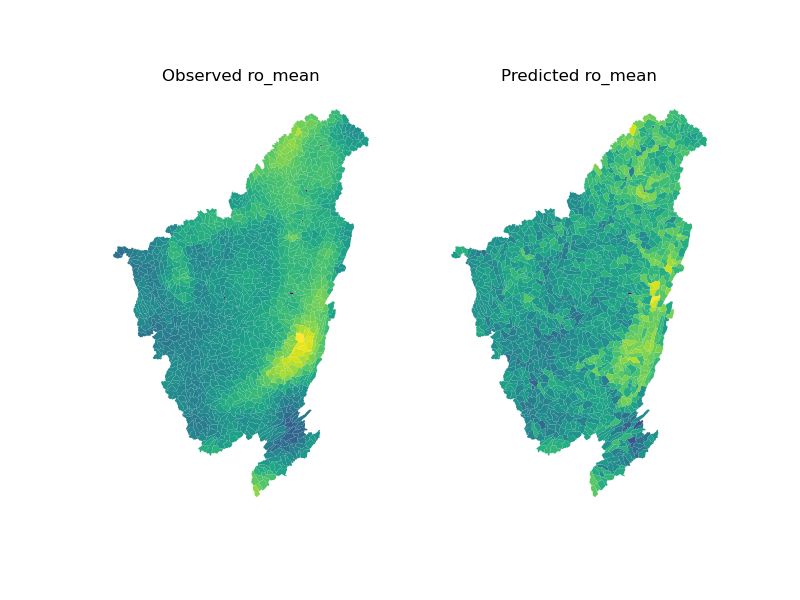

In [6]:
from matplotlib.colors import LogNorm

var_name = 'ro_mean'

# date_str = '2020-07-26'
# day_preds = results.xs(date_str, level='date')['pred']['discharge']
# has_gauge = ~results.xs(date_str, level='date')['obs']['discharge'].isna().rename('has_gauge')
# day_results = pd.concat([day_preds, has_gauge], axis=1)
# spatial_results = hybas.merge(day_results, how='inner', left_index=True, right_index=True)

avg = results.groupby('basin').mean()
avg_pred = avg['pred'][f'{var_name}'].rename('pred')
avg_obs = avg['obs'][f'{var_name}'].rename('obs')
has_gauge = ~avg_obs.isna().rename('has_gauge')
avg_results = pd.concat([avg_obs, avg_pred, has_gauge], axis=1)
spatial_results = hybas.merge(avg_results, how='inner', left_index=True, right_index=True)

plt.close('all')
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

# norm = LogNorm(vmin=-4, vmax=-2)
cmap = 'inferno'
spatial_results.plot('obs', ax=axes[0])#, norm=norm, cmap=cmap)
# spatial_results[spatial_results["has_gauge"]].plot(edgecolor="red", facecolor="none", linewidth=1, ax=axes[0])

axes[0].set_axis_off()
axes[0].set_title(f'Observed {var_name}')
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])  # Dummy array for colorbar
# cbar = plt.colorbar(sm, ax=axes[0])
# cbar.set_label('ro_mean')


norm = LogNorm(vmin=100, vmax=100000)
cmap = 'inferno'
spatial_results.plot('pred', ax=axes[1])#, norm=norm, cmap=cmap)
axes[1].set_axis_off()
axes[1].set_title(f'Predicted {var_name}')
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])  # Dummy array for colorbar
# cbar = plt.colorbar(sm, ax=axes[1])
# cbar.set_label('Area')

plt.show()


In [ ]:
key = jax.random.PRNGKey(0)
batch_keys = jax.random.split(key, cfg['batch_size'])

dataloader = HydroDataLoader(cfg, dataset)
for basin, date, batch in tqdm(dataloader):
    batch = trainer.dataloader.shard_batch(batch)
    
    loss, grads, new_model, new_opt_state = train.step.make_step(
        trainer.model, 
        batch,
        batch_keys,
        trainer.opt_state, 
        trainer.optim, 
        trainer.filter_spec, 
        trainer.dataloader.dataset.denormalize_target,
        **trainer.cfg['step_kwargs']
    )
    
    if np.isnan(loss):
        break
    else:
        trainer.model = new_model
        trainer.opt_state = new_opt_state
    break

In [ ]:
np.isnan(loss)

In [ ]:
batch = trainer.dataloader.shard_batch(batch)
batch['dynamic_dt']['era5'].device

In [ ]:
cell = trainer.model.encoders['landsat'].cell
cell

In [ ]:
cfg['model_args']['

In [ ]:
x_d = batch['dynamic']['landsat'][0]
x_s = batch['static'][0]
static_bias = trainer.model.static_embedder(x_s, key)

h_0 = jnp.zeros(cfg['model_args']['hidden_size'])
dt = 1

time_weight = cell.time_distance(dt, static_bias)
time_weight.shape

In [ ]:
# lax.scan 
for x in x_d:
    if jnp.all(~jnp.isnan(x)):
        break
x

In [ ]:
gates = jnp.dot(x, cell.weight_ih.T) + jnp.dot(h_0, cell.weight_hh.T) + cell.bias
f, g, o = jnp.split(gates, 3, axis=-1)
i = jax.nn.sigmoid(cell.input_linear(static_bias))

f = jax.nn.sigmoid(f) * time_weight

In [ ]:
import jax.numpy as jnp

params = jnp.split(trainer.model.encoders['landsat'].cell.decay_weights, 2, axis=0)

In [ ]:
params[0,:].shape

In [ ]:
trainer.model.encoders['landsat'].cell

In [ ]:
batch = dataloader.shard_batch(batch)

batch['dynamic_dt']['landsat'].device

In [ ]:
first_values.shape

In [ ]:
last_valid_index.shape

In [ ]:
x_d = batch['dynamic']['landsat']
# x_s = batch['static'][0]



valid_mask = np.all(~np.isnan(x_d),axis=2)

# valid_mask[0] = True

indices = np.arange(valid_mask.shape[1])
                  
valid_indices = np.where(valid_mask, indices, -1)


last_valid_index = np.maximum.accumulate(valid_indices, axis=1) 

first_values = valid_mask[:,0].astype(int)[:, None]
dt = np.concat([first_values, np.diff(last_valid_index, axis=1)],axis=1)


dt[1]


In [ ]:
dt[0]

In [ ]:
plt.close('all')
plt.imshow(dt)#,aspect='auto')

In [ ]:
alt_cfg = cfg.copy()
alt_cfg['batch_size'] = 1
dataloader = TAPDataLoader(alt_cfg, dataset)

for basin, date, batch in dataloader:
    break
    
single_data = {k: v[0,...] for k, v in batch.items()}

In [ ]:
trainer.model(single_data, jax.random.PRNGKey(0))

In [ ]:
batch['y'][0,...].shape

In [ ]:
# Resume training. Either directly from memory or loading a checkpoint.
import optax

# trainer.load_state('epoch100')
# trainer.load_last_state()

more_epochs = 0
new_schedule = optax.exponential_decay(0.01, trainer.epoch+more_epochs, 0.001, transition_begin=trainer.epoch)
trainer.lr_schedule = new_schedule
trainer.num_epochs += more_epochs

#Have to make a new dataloader when the last one is interrupted. 
trainer.dataloader = TAPDataLoader(cfg, dataset) 
trainer.start_training() 

In [ ]:
reload(evaluate)
from evaluate import predict, get_all_metrics

# basin = np.random.choice(dataset.basins).tolist()
basin = 'USGS-09367540'

cfg['data_subset'] = 'predict'
cfg['basin_subset'] =  basin
cfg['num_workers'] = 0 # Faster for small runs
dataloader = TAPDataLoader(cfg, dataset)

results = predict(trainer.model, dataloader, seed=0, denormalize=True)
results['pred'] = results['pred'] * (results['pred']>0) #Clip predictions to 0

results = results.reset_index()
results = results.sort_values(by='date')
results = results.drop(columns=['basin'], axis=1, level=0)
results.set_index('date', inplace=True)


In [ ]:
feature = 'usgs_q'

# Plot the true values and predictions
fig, ax = plt.subplots(figsize=(12, 6))
results['pred'][feature].plot(ax=ax)
results['obs'][feature].plot(ax=ax,linestyle='None',marker='.')

plt.title(f"Basin: {basin}")
plt.legend()
fig.autofmt_xdate()
# plt.ylim([0,20000])
plt.show()

In [ ]:
basin

In [ ]:
"""
'USGS-09367540'
"""

In [ ]:
results.plot.scatter('obs','pred')
plt.gca().axis('square')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim([0,20])
# plt.ylim([0,20])
plt.show()

In [ ]:
import train
from data import TAPDataset, TAPDataLoader

state_dir = Path("../runs/notebook/20240603_1359/epoch18")
cfg, model, trainer_state, opt_state = train.load_state(state_dir)
dataset = TAPDataset(cfg)

In [ ]:
reload(evaluate)
from evaluate import predict, get_all_metrics

cfg['data_subset'] = 'test'
cfg['num_workers'] = 4
dataloader = TAPDataLoader(cfg, dataset)

results = predict(model, dataloader, seed=0, denormalize=True)
results['pred'] = results['pred']# * (results['pred']>0) #Clip predictions to 0

# results = results.reset_index()
# results = results.sort_values(by='date')

metrics = get_all_metrics(results['obs'],results['pred'])
metrics

In [ ]:
%matplotlib widget
plt.close('all')
plt.scatter(batch['y'][...,-1],pred[...,-1])
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))
xd = axes[0].imshow(batch['x_dd'][:,:,0],aspect='auto')
fig.colorbar(xd, ax=axes[0])
xs = axes[1].imshow(batch['x_s'],aspect='auto')
fig.colorbar(xs, ax=axes[1]) 

In [ ]:
batch['x_dd'][:,:,0].shape

In [ ]:
basins[idx_max_err]

In [ ]:
positional_encoding = trainer.model.d_encoder.embedder.positional_encoding

plt.figure(figsize=(10, 8))
plt.imshow(positional_encoding, cmap='viridis')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')
plt.title('Positional Encodings')
plt.show()